In [4]:
import matplotlib.patches as patches
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import pandas as pd
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

COMMON_MODEL = ['CMCC-ESM2', 'CESM2-WACCM','NorESM2-MM', 'TaiESM1', 'EC-Earth3-Veg','CMCC-CM2-SR5', 'BCC-CSM2-MR']
CALS = ['rh', 'soc']
MODEL_INPUT_PATH = "F:/007-2_MMWM_data_CMIP6"
OUTPUT_PATH = "E:/Drought_And_SOC/res/figs/Supplementary"

# 定义模型样式
MODEL_STYLES = {
    'CMCC-ESM2': {'color': 'red', 'label': 'CMCC-ESM2'},
    'CESM2-WACCM': {'color': 'blue', 'label': 'CESM2-WACCM'},
    'NorESM2-MM': {'color': 'green', 'label': 'NorESM2-MM'},
    'TaiESM1': {'color': 'purple', 'label': 'TaiESM1'},
    'EC-Earth3-Veg': {'color': 'orange', 'label': 'EC-Earth3-Veg'},
    'CMCC-CM2-SR5': {'color': 'brown', 'label': 'CMCC-CM2-SR5'},
    'BCC-CSM2-MR': {'color': 'pink', 'label': 'BCC-CSM2-MR'}
}

# 定义变量样式
CAL_MARKERS = {
    'rh': 'o',       # 原点
    'soc': '^',       # 三角形
}

CONTINENT_DICT = {
    'Asia': 0,
    'North America': 1,
    'Europe': 2,
    'Africa': 3,
    'South America': 4,
    'Oceania': 5
}

In [5]:
def plot_supplementary_fig6a(fig, ax, continent):
    all_weights = {cal: {} for cal in CALS}  # 初始化嵌套字典
    scatter_handles = []  # 用于存储散点图的图例句柄
    for cal in CALS:
        weight_path = f"{MODEL_INPUT_PATH}/{continent}_{cal}_weight.csv"
        weight_df = pd.read_csv(weight_path)
        skill_weight = weight_df['weight_skill']
        uniqueness_weight = weight_df['weight_uniqueness']
        for model in COMMON_MODEL:
            all_weights[cal][model] = {
                'skill': skill_weight[weight_df[weight_df.columns[0]] == model].values[0],
                'uniqueness': uniqueness_weight[weight_df[weight_df.columns[0]] == model].values[0]
            }

    # 准备散点图的坐标、颜色和标签
    skill_vals = []
    uniqueness_vals = []
    colors = []
    markers = []
    labels = []

    for cal in CALS:
        marker = CAL_MARKERS[cal]
        for model in COMMON_MODEL:
            if model in all_weights[cal]:
                data = all_weights[cal][model]
                color = MODEL_STYLES[model]['color']
                label = f"{cal}-{model}"

                skill_vals.append(data['skill'])
                uniqueness_vals.append(data['uniqueness'])
                colors.append(color)
                markers.append(marker)
                labels.append(label)

    # 使用单个scatter调用绘制所有点
    scatter_handles = []  # 存储散点图的句柄
    for i in range(len(skill_vals)):
        sc = ax.scatter(
            skill_vals[i],
            uniqueness_vals[i],
            s=100,
            c=colors[i],
            marker=markers[i],
            edgecolors='black',
            linewidths=1,
            alpha=0.9,
            label=labels[i]
        )
        scatter_handles.append(sc)

    # 设置坐标轴标签和范围
    if continent != 'Oceania':
        ax.set_title(f"{continent}", fontsize=20)
    else:
        ax.set_title(f"Australia", fontsize=20)
    if continent == 'South America' or continent == 'Oceania':
        ax.set_xlabel('Skill Weight', fontsize=20)
    if continent == 'South America' or continent == 'Asia' or continent == 'Europe':
        ax.set_ylabel('Uniqueness Weight', fontsize=20)
    ax.tick_params(axis='x', labelsize=16)  # 设置 x 轴刻度字体大小
    ax.tick_params(axis='y', labelsize=16)  # 设置 y 轴刻度字体大小

    # 计算等权重线 (skill * uniqueness = constant)
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    # 设置合理的常数范围（根据实际数据范围调整）
    min_const = 0.05
    max_const = min(x_max * y_max, 2)  # 确保不超过0.5
    constants = np.arange(min_const, max_const, 0.25)

    for const in constants:
        x = np.linspace(max(x_min, const/y_max), min(x_max, const/y_min), 100)
        y = const / x

        # 仅绘制在可见范围内的曲线
        valid = (y >= y_min) & (y <= y_max) & (x >= x_min) & (x <= x_max)
        if np.any(valid):
            ax.plot(x[valid], y[valid], 'k--', alpha=0.4, lw=0.8)

            # 在曲线中间位置标注常数（避免边界）
            mid_idx = len(x[valid]) // 2
            x_mid = x[valid][mid_idx]
            y_mid = y[valid][mid_idx]

            # 确保标注位置在图形内部
            if (x_min < x_mid < x_max) and (y_min < y_mid < y_max):
                ax.text(x_mid, y_mid, f'{const:.2f}',fontsize=16, alpha=0.8, ha='center', va='center')

    return scatter_handles, labels

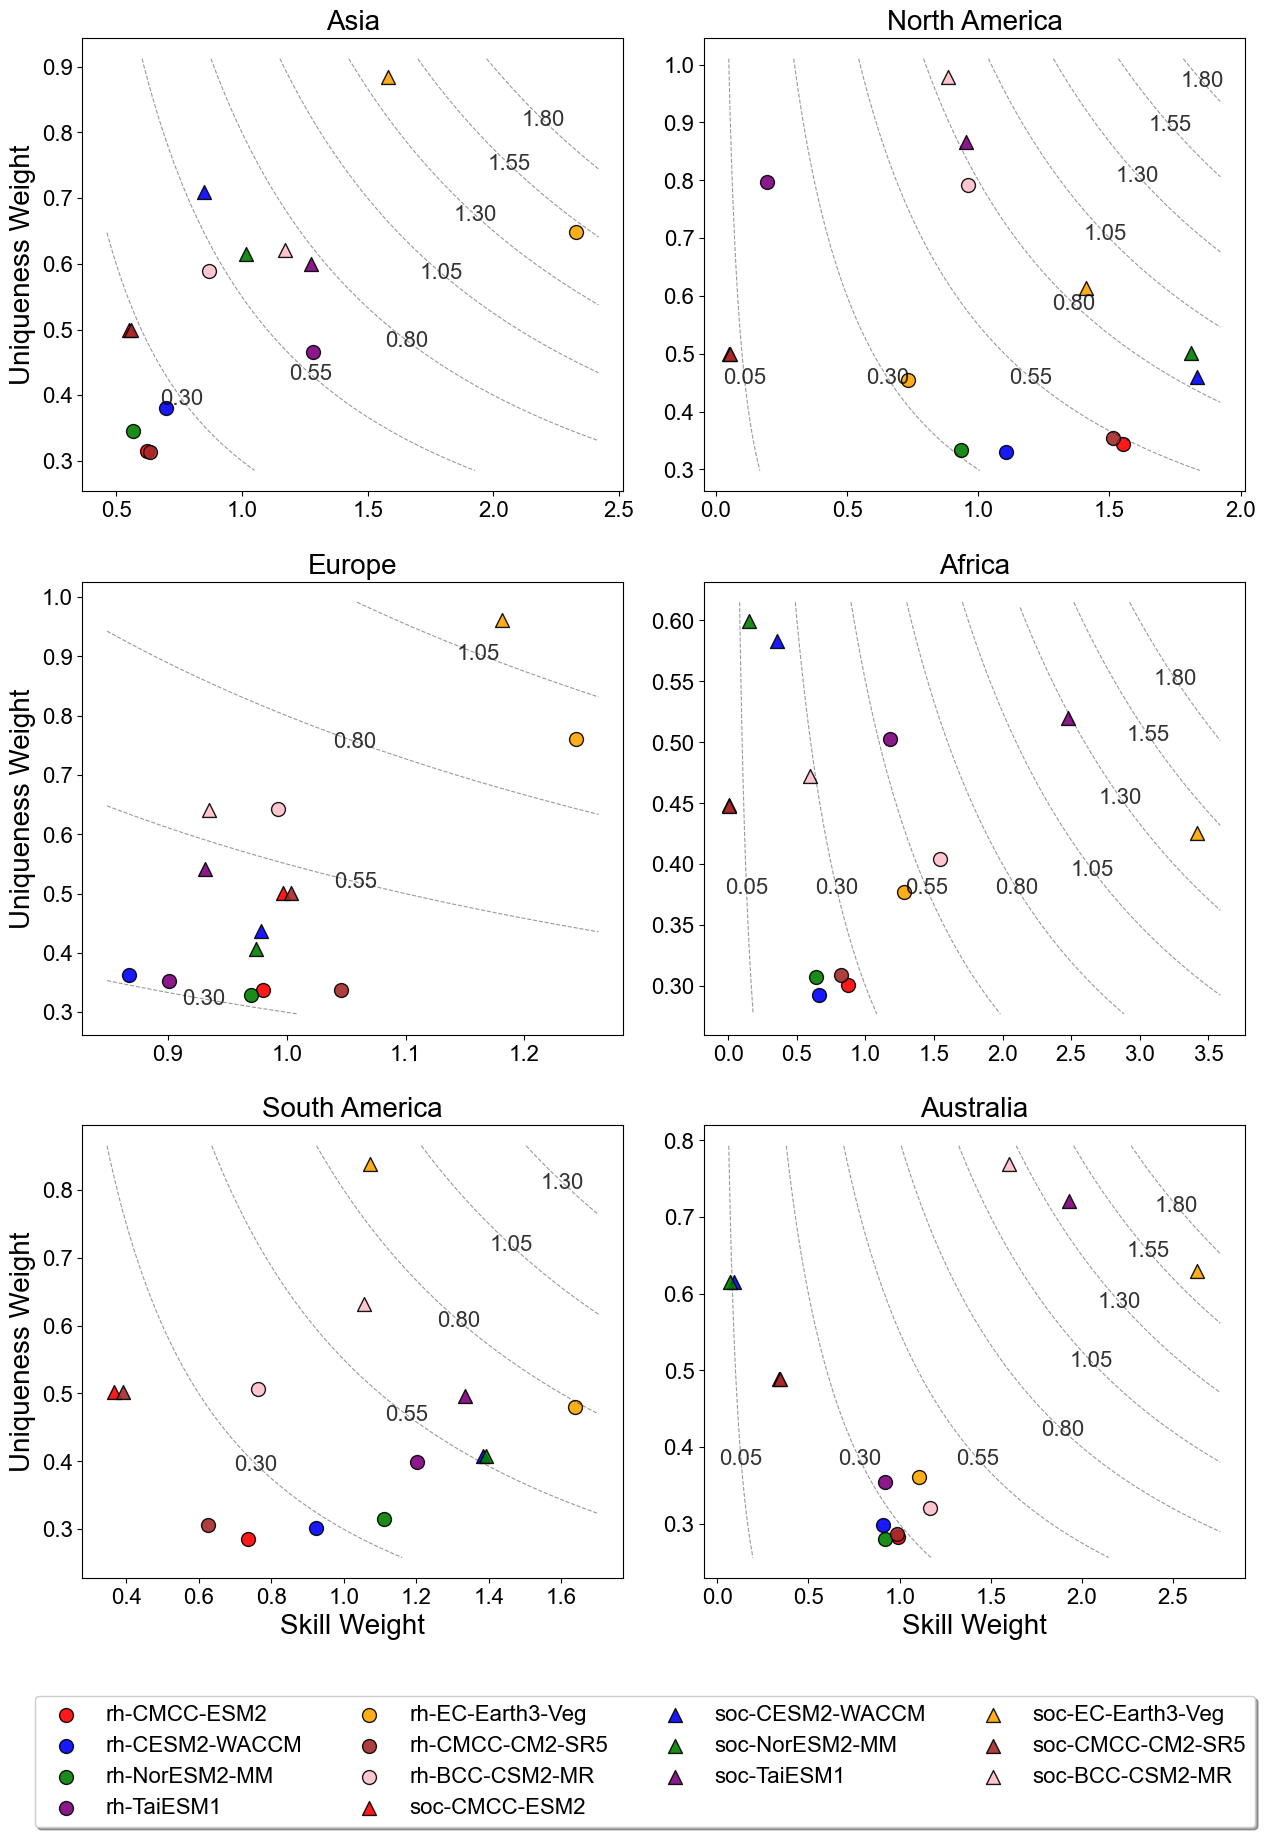

In [6]:
def create_supplementary_fig6():
    plt.rcParams.update({
        'font.family': 'serif',           # 主字体类型（serif衬线 / sans-serif无衬线）
        'font.serif': ['Arial'], # 衬线字体首选
        'font.sans-serif': ['Times New Roman'],      # 无衬线字体备选
    })
    # 创建图形和子图布局
    fig = plt.figure(figsize=(15, 20))

    # 用于收集所有图例项的列表
    all_handles = []
    all_labels = []

    # 标记是否已经收集过图例项
    legend_collected = False

    for key, value in dict(CONTINENT_DICT).items():
        # 创建m×n的子图布局（根据实际需求调整）
        gs = gridspec.GridSpec(3, 2, figure=fig)
        ax = fig.add_subplot(gs[value])
        handles, labels = plot_supplementary_fig6a(fig, ax, key)

        # 只收集一次图例项（避免重复）
        if not legend_collected:
            all_handles.extend(handles)
            all_labels.extend(labels)
            legend_collected = True

    # 在整个图形下方添加图例（居中位置）
    fig.legend(
        handles=all_handles,
        labels=all_labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.02),  # 位于图形底部中间
        fancybox=True,
        shadow=True,
        ncol=4,  # 分成4列
        fontsize=16,  # 稍微减小字体大小
        frameon=True
    )

    plt.subplots_adjust(wspace=0.15, hspace=0.2)
    plt.show()


if __name__ == '__main__':
    create_supplementary_fig6()